In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import timeit
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, average_precision_score, matthews_corrcoef
from util import heat_map, xai_eval_fnc

2023-03-06 01:17:17.824939: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 01:17:22.627393: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-06 01:17:27.016599: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-06 01:17:27.016673: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
# %load_ext autoreload
# %reload_ext util

In [3]:
##### load data and reformat
data = np.load('train_test_x_y.npz')
train_x, test_x, train_y, test_y  = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3'] 
train_y = train_y.reshape(-1,1)
test_y  = test_y.reshape(-1,1)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)



(18390, 48, 26) (4598, 48, 26) (18390, 1) (4598, 1)


In [4]:
#### load model

model = keras.models.load_model('mimic3_ts_transformer_4march_wattscores_48x26x26.h5_best.hdf5', compile=False)

2023-03-06 01:17:39.544015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 01:17:40.480089: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 01:17:40.480350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 01:17:40.495451: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
print(roc_auc_score(test_y, model.predict(test_x, verbose=0)))
print(average_precision_score(test_y, model.predict(test_x, verbose=0)))
print(f1_score(test_y, np.round(model.predict(test_x, verbose=0))))
print(recall_score(test_y, np.round(model.predict(test_x, verbose=0))))
print(precision_score(test_y, np.round(model.predict(test_x, verbose=0))))
print(matthews_corrcoef(test_y, np.round(model.predict(test_x, verbose=0))))

2023-03-06 01:18:02.837255: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500


0.6110341117650782
0.1505385556359674
0.20408163265306123
0.2183406113537118
0.19157088122605365
0.10989155255655954


In [6]:
############# load wSHAP scores obtained from HPC

ts_phi_1 = np.load('mhat_ts_phi_1.npy') #p1-p50
ts_phi_2 = np.load('mhat_ts_phi_2.npy') #p1-p50
ts_phi_3 = np.load('mhat_ts_phi_3.npy') #p1-p50

In [8]:
ts_phi_1.shape, ts_phi_2.shape, ts_phi_3.shape

((50, 48, 26), (50, 48, 26), (50, 48, 26))

In [9]:
######## visualization of wSHAP scores
feature_map_mimic_26 = ['ANION GAP', 'ALBUMIN', 'BICARBONATE', 'BILIRUBIN','CREATININE', 'CHLORIDE', 'GLUCOSE', 'HEMATOCRIT', 
                     'LACTATE', 'MAGNESIUM', 'PHOSPHATE','PLATELET', 'POTASSIUM', 'PTT','INR', 'PT', 
                     'SODIUM', 'BUN', 'WBC', 'HeartRate', 'SysBP', 'DiasBP', 'MeanBP', 'RespRate', 'SpO2','Temp']

In [10]:
num_test = 0 #50 in next turn
var = 18        #### feature index
phi_index = 0   #### patient index

## Heatmap for Stationary SHAP

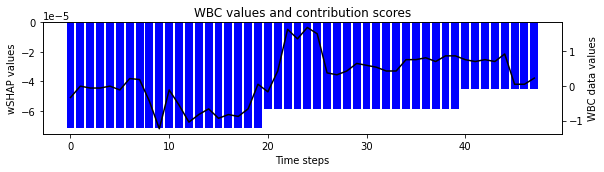

In [12]:
heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=ts_phi_1[num_test + phi_index, :, var], var_name=feature_map_mimic_26[var], plot_type='bar')

## Heatmap for Sliding SHAP

In [14]:
# heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=ts_phi_2[num_test + phi_index, :, var], var_name=feature_map_mimic_26[var], plot_type='bar')

## Heatmap for Dynamic SHAP

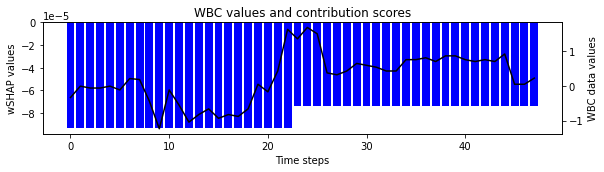

In [15]:
heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=ts_phi_3[num_test + phi_index, :, var], var_name=feature_map_mimic_26[var], plot_type='bar')

In [ ]:
########## perturbation and seq based analysis; change in loss and metrics